In [16]:
import keras
import os, shutil, os.path
import pandas as pd
import numpy as np
import re
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
import matplotlib.pyplot as plt

In [17]:
keras.__version__

'2.2.4'

In [18]:
df1 = pd.read_csv('../all_files_biglabel_nov19.csv')
df2 = pd.read_csv('/Users/shelly/Google Drive/CPE695/pub_priv.csv')
df3 = pd.merge(df1, df2, on='label', how='inner')
df3.dropna(subset=['pub_priv'], inplace=True)

df3.groupby('pub_priv').count()

,filename,label,biglabel
pub_priv,,,
private,4406,4406,4406
public,6209,6209,6209


In [19]:
df3.groupby(['pub_priv']).label.nunique()

pub_priv
private    18
public     27
Name: label, dtype: int64

In [20]:
# remove invalid images
df3 = df3.drop(df3.index[df3.filename == 'trainstation_30.jpg'])
df3 = df3.drop(df3.index[df3.filename == 'bookstore_56.jpg'])
df3 = df3.drop(df3.index[df3.filename == 'dining_room_49.jpg'])
df3 = df3.drop(df3.index[df3.filename == 'laboratorywet_25.jpg'])
df3 = df3.drop(df3.index[df3.filename == 'mall_39.jpg'])
df3 = df3.drop(df3.index[df3.filename == 'shoeshop_23.jpg'])

In [21]:
# split training and testing data
train = df3[:8000]
test = df3[8000:10000]

In [22]:
# create datagenerators
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [23]:
DIR = "../Images_all"
train_generator=datagen.flow_from_dataframe(dataframe=train,
                                            directory=DIR,
                                            x_col="filename",
                                            y_col="pub_priv",
                                            subset="training",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=(150,150))
valid_generator=datagen.flow_from_dataframe(dataframe=train,
                                            directory=DIR,
                                            x_col="filename",
                                            y_col="pub_priv",
                                            subset="validation",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=(150,150))
# test_generator=test_datagen.flow_from_dataframe(dataframe=test,
#                                                 directory=DIR,
#                                                 x_col="filename",
#                                                 y_col=None,
#                                                 batch_size=32,
#                                                 seed=42,
#                                                 shuffle=False,
#                                                 class_mode=None,
#                                                 target_size=(150,150))

Found 6000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [24]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [26]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=valid_generator,
      validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 75s 754ms/step - loss: 0.6269 - acc: 0.6372 - val_loss: 0.6029 - val_acc: 0.6794
Epoch 2/30
100/100 [==============================] - 64s 642ms/step - loss: 0.6100 - acc: 0.6541 - val_loss: 0.6108 - val_acc: 0.6730
Epoch 3/30
100/100 [==============================] - 70s 701ms/step - loss: 0.5855 - acc: 0.6853 - val_loss: 0.6092 - val_acc: 0.6799
Epoch 4/30
100/100 [==============================] - 85s 854ms/step - loss: 0.5682 - acc: 0.6997 - val_loss: 0.6327 - val_acc: 0.6812
Epoch 5/30
100/100 [==============================] - 84s 842ms/step - loss: 0.5535 - acc: 0.7225 - val_loss: 0.5602 - val_acc: 0.7106
Epoch 6/30
100/100 [==============================] - 83s 833ms/step - loss: 0.5297 - acc: 0.7325 - val_loss: 0.5635 - val_acc: 0.7102
Epoch 7/30
100/100 [==============================] - 86s 859ms/step - loss: 0.4999 - acc: 0.7578 - val_loss: 0.5312 - val_acc: 0.7292
Epoch 8

In [27]:
model.save('pub_priv.h5')

In [28]:
def plot_train_val_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    import matplotlib.pyplot as plt
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

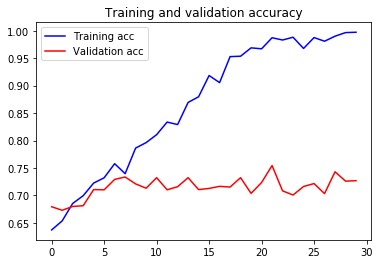

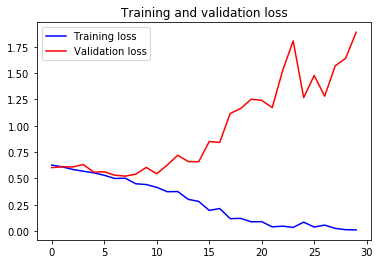

In [29]:
plot_train_val_acc(history)

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=test,
                                                directory=DIR,
                                                x_col="filename",
                                                y_col="pub_priv",
                                                shuffle=False,
                                                batch_size=1,
                                                class_mode='binary',
                                                target_size=(150,150))

predict = model.predict_generator(test_generator, steps=len(test))

Found 2000 validated image filenames belonging to 2 classes.


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
test_labels = test_generator.classes
score = accuracy_score(test_labels, predict.round())
print("The accruacy score is %f" % score)
print(classification_report(test_labels, predict.round()))

The accruacy score is 0.655500
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       989
           1       0.64      0.74      0.68      1011

    accuracy                           0.66      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.66      0.66      0.65      2000



# Image Augmentation

In [34]:
train_datagen2 = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.25)
test_datagen2 = ImageDataGenerator(rescale=1./255)

In [36]:
DIR = "../Images_all"
train_generator=train_datagen2.flow_from_dataframe(dataframe=train,
                                            directory=DIR,
                                            x_col="filename",
                                            y_col="pub_priv",
                                            subset="training",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=(150,150))
valid_generator=train_datagen2.flow_from_dataframe(dataframe=train,
                                            directory=DIR,
                                            x_col="filename",
                                            y_col="pub_priv",
                                            subset="validation",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=(150,150))
test_generator=test_datagen2.flow_from_dataframe(dataframe=test,
                                                directory=DIR,
                                                x_col="filename",
                                                y_col=None,
                                                batch_size=32,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(150,150))

Found 6000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames.


In [37]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation='relu'))
# binary class classification
model2.add(layers.Dense(1, activation='sigmoid'))   # Final Layer using sigmoid
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [39]:
history2_aug = model2.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=valid_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 96s 956ms/step - loss: 0.6509 - acc: 0.6141 - val_loss: 0.6648 - val_acc: 0.6131
Epoch 2/30
100/100 [==============================] - 91s 911ms/step - loss: 0.6190 - acc: 0.6519 - val_loss: 0.6091 - val_acc: 0.6742
Epoch 3/30
100/100 [==============================] - 90s 898ms/step - loss: 0.6164 - acc: 0.6441 - val_loss: 0.6355 - val_acc: 0.6458
Epoch 4/30
100/100 [==============================] - 87s 873ms/step - loss: 0.6207 - acc: 0.6628 - val_loss: 0.6642 - val_acc: 0.6319
Epoch 5/30
100/100 [==============================] - 89s 889ms/step - loss: 0.5990 - acc: 0.6572 - val_loss: 0.6231 - val_acc: 0.6763
Epoch 6/30
100/100 [==============================] - 89s 886ms/step - loss: 0.5971 - acc: 0.6713 - val_loss: 0.6225 - val_acc: 0.6439
Epoch 7/30
100/100 [==============================] - 87s 871ms/step - loss: 0.5961 - acc: 0.6728 - val_loss: 0.5909 - val_acc: 0.6913
Epoch 8/30
100/100 [==============================] - 8

In [40]:
model2.save('pub_priv_second_augmented.h5')

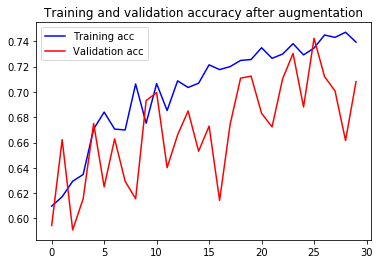

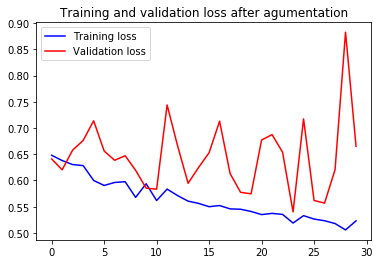

In [169]:
acc = history2_aug.history['acc']
val_acc = history2_aug.history['val_acc']
loss = history2_aug.history['loss']
val_loss = history2_aug.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy after augmentation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss after agumentation')
plt.legend()

plt.show()


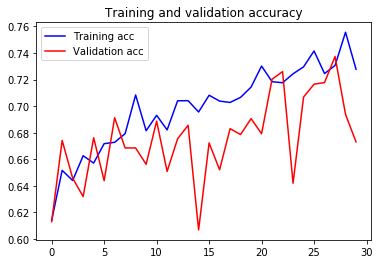

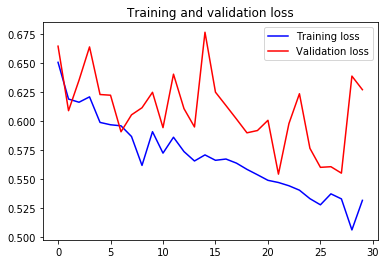

In [41]:
plot_train_val_acc(history2_aug)

In [46]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=test,
                                                directory=DIR,
                                                x_col="filename",
                                                y_col="pub_priv",
                                                shuffle=False,
                                                batch_size=1,
                                                class_mode='binary',
                                                target_size=(150,150))

predict2 = model2.predict_generator(test_generator, steps=len(test))

Found 2000 validated image filenames belonging to 2 classes.


In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
test_labels = test_generator.classes
score2 = accuracy_score(test_labels, predict2.round())
print("The accruacy score is %f" % score)
print(classification_report(test_labels, predict2.round()))

The accruacy score is 0.655500
              precision    recall  f1-score   support

           0       0.76      0.17      0.28       989
           1       0.54      0.95      0.69      1011

    accuracy                           0.56      2000
   macro avg       0.65      0.56      0.49      2000
weighted avg       0.65      0.56      0.49      2000



## Using a pre-trained convnet: ResNet50


In [71]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.applications import VGG16

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

- weights, to specify which weight checkpoint to initialize the model from
- include_top, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
- input_shape, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

In [54]:
conv_base.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [103]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')
DIR = "../Images_all"
# train_datagen2 = ImageDataGenerator(rescale=1./255,
#                                     rotation_range=40,
#                                     width_shift_range=0.2,
#                                     height_shift_range=0.2,
#                                     shear_range=0.2,
#                                     zoom_range=0.2,
#                                     horizontal_flip=True,
#                                     validation_split=0.25)
train_datagen2 = ImageDataGenerator(rescale=1./255, validation_split=0.25)
test_datagen2 = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen2.flow_from_dataframe(dataframe=train,
                                            directory=DIR,
                                            x_col="filename",
                                            y_col="pub_priv",
                                            subset="training",
                                            batch_size=15,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=(150,150))
valid_generator=train_datagen2.flow_from_dataframe(dataframe=train,
                                            directory=DIR,
                                            x_col="filename",
                                            y_col="pub_priv",
                                            subset="validation",
                                            batch_size=15,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=(150,150))
test_generator=test_datagen2.flow_from_dataframe(dataframe=test,
                                                directory=DIR,
                                                x_col="filename",
                                                y_col="pub_priv",
                                                batch_size=15,
                                                class_mode="binary",
                                                target_size=(150,150))



Found 6000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [104]:
# feature extraction
def extract_features(generator, sample_count, batch_size = 15):
    
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape=(sample_count))
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_generator, 6000)
validation_features, validation_labels = extract_features(valid_generator, 2000)
test_features, test_labels = extract_features(test_generator, 2000)

The extracted features are currently of shape (samples,5, 5, 2048). We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 51200):

In [106]:
train_features = np.reshape(train_features, (6000, 5 * 5 * 2048))
validation_features = np.reshape(validation_features, (2000, 5 * 5 * 2048))
test_features = np.reshape(test_features, (2000, 5 * 5 * 2048))

In [133]:
train_features.shape

(6000, 51200)

# At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and labels that we just recorded:

In [136]:
from keras import models
from keras import layers
from keras import optimizers

# Define model
epochs = 30
clf1 = models.Sequential()
# model.add(Flatten(input_shape=(5,5,2048)))
clf1.add(layers.Dense(512, activation='relu', input_dim=(5 * 5 * 2048)))
clf1.add(layers.Dropout(0.5))
clf1.add(layers.Dense(1, activation='sigmoid'))
clf1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               26214912  
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 513       
Total params: 26,215,425
Trainable params: 26,215,425
Non-trainable params: 0
_________________________________________________________________


In [137]:
clf1.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history_clf1 = clf1.fit(train_features, train_labels,
                        epochs=30,
                        batch_size=20,
                        validation_data=(validation_features, validation_labels))

Train on 6000 samples, validate on 2000 samples
Epoch 1/30
6000/6000 [==============================] - 108s 18ms/step - loss: 0.6727 - acc: 0.5990 - val_loss: 0.6315 - val_acc: 0.5965
Epoch 2/30
6000/6000 [==============================] - 98s 16ms/step - loss: 0.6228 - acc: 0.6342 - val_loss: 0.6056 - val_acc: 0.6540
Epoch 3/30
6000/6000 [==============================] - 97s 16ms/step - loss: 0.6080 - acc: 0.6490 - val_loss: 0.6010 - val_acc: 0.6650
Epoch 4/30
6000/6000 [==============================] - 96s 16ms/step - loss: 0.6008 - acc: 0.6507 - val_loss: 0.5769 - val_acc: 0.7115
Epoch 5/30
6000/6000 [==============================] - 93s 15ms/step - loss: 0.5913 - acc: 0.6800 - val_loss: 0.5931 - val_acc: 0.6605
Epoch 6/30
6000/6000 [==============================] - 95s 16ms/step - loss: 0.5826 - acc: 0.6758 - val_loss: 0.5705 - val_acc: 0.7050
Epoch 7/30
6000/6000 [==============================] - 93s 16ms/step - loss: 0.5827 - acc: 0.6855 - val_loss: 0.5803 - val_acc: 0.6935

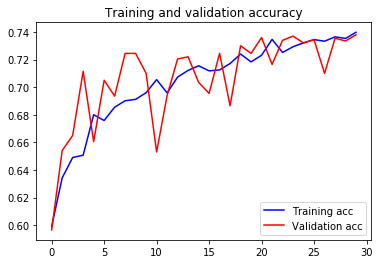

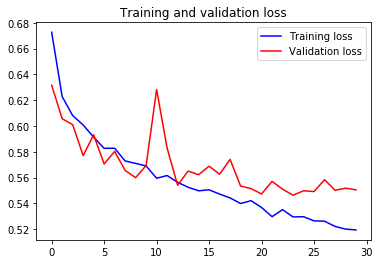

In [142]:
plot_train_val_acc(history_clf1)

In [157]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
test_predict_1=clf1.predict(test_features)
score = accuracy_score(test_labels, test_predict_1.round())
print("The accruacy score is %f" % score)
print(classification_report(test_labels, test_predict_1.round()))

The accruacy score is 0.650500
              precision    recall  f1-score   support

         0.0       0.64      0.66      0.65       989
         1.0       0.66      0.64      0.65      1011

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



# cl2 = svm classifier

In [158]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, 
                               validation_features))

svm_labels = np.concatenate((train_labels, 
                             validation_labels))

In [160]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV

# Build model

X_train, y_train = svm_features.reshape(8000,5 * 5 * 2048), svm_labels
param = [{"C": [0.01, 0.1, 1, 10, 100]}]
svm = LinearSVC(penalty='l2', loss='squared_hinge')
clf2= GridSearchCV(svm, param, cv=10)

In [162]:
clf2.fit(X_train, y_train)

/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/shelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [163]:
test_predict_2=clf2.predict(test_features.reshape(2000,5 * 5 * 2048))

In [164]:
score2 = accuracy_score(test_labels, test_predict_2.round())
print("The accruacy score is %f" % score)
print(classification_report(test_labels, test_predict_2.round()))

The accruacy score is 0.650500
              precision    recall  f1-score   support

         0.0       0.66      0.57      0.61       989
         1.0       0.63      0.71      0.66      1011

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000



In [165]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV

# Build model

X_train, y_train = svm_features.reshape(8000,5 * 5 * 2048), svm_labels
param = [{"C": [0.8, 1, 1.1]}]
svm3 = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=2000)
clf3= GridSearchCV(svm3, param, cv=10)
clf2.fit(X_train, y_train)

## vgg16_places_365
weights='places'

In [173]:
from keras.applications import VGG16
path = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'
conv_base_2 = VGG16(weights=path,
                  include_top=False,
                  input_shape=(150, 150, 3))

ValueError: The `weights` argument should be either `None` (random initialization), `imagenet` (pre-training on ImageNet), or the path to the weights file to be loaded.